In [7]:
# this notebook will implement the predictive abrasion model using an explicit accounting of mass conservation
# we assume a constant thickness of sediment
# and allow percentages of different lithologies to change through time and space

In [8]:
# first, outline the math

#### <i>CELL VOLUME</i>

$$ \text{volume} = whdx$$

where $w$ = width, $h$ = height, and $dx$ = length

<br>
<br>

#### <i>MASS</i>

$$m = \lambda \times \text{volume} \times (1 - \phi) \times \rho$$

where $\lambda$ = the percentage of a given material in the basin (igneous, metamorphic, or sedimentary), $\phi$ = porosity within the bed, and $\rho$ = the material density

<br>
<br>

#### <i>STATEMENT OF MASS CONSERVATION:</i>

$$ \text{rate of change of igneous mass} = \text{mass rate in} - \text{mass rate out} - \text{mass lost to abrasion}$$

A rate of mass change is $[M/t]$, so mass per time are the units we're shooting for everywhere.

<br>
<br>

#### <i>WRITING MASS CONSERVATION IN TERMS OF STUFF WE CAN CALCULATE IN OUR MODEL</i>

In our model, we can calculate a bedload sediment flux as a function of slope, discharge (itself a function of upstream contributing area), and some lumped factors that derive from equilibrium channel theory (excess shear stress, etc. See Wickert & Schildgen, 2019). This would look like

$$Q_s = c Q S$$

where $c$ is the lumped coefficient, $Q$ is discharge, and $S$ is bed slope. $c$ and $S$ are dimensionless, so $Q_s$ has the same dimensions as $Q$. Traditionally, dimensions of a water discharge or sediment yield would be $[V/t]$, volume per time, or $[L^3/t]$. Remember,

$$\text{mass} = \text{density} \times \text{volume}$$

$$[M] = [M/V] \times [V]$$

But, as a means of normalizing to channel width, we reduce the sediment flux to a unit sediment discharge, i.e. a flux per unit width. This can be written as

$$q_s = \frac{Q_s}{w}$$

Now $q_s$ represents the unit sediment flux, which has dimensions $[L^2/t]$ - basically, an area per time. This is a little bit of a problem since a volume per time is what we need to combine with material density in order to transform the dimesions of the right-hand side of our equation to the dimensions of the left-hand side, which are mass per time. If we write it all out, it looks like this:

$$\frac{\partial m}{\partial t} = \rho_{ig} q_s|_x w - \rho_{ig} q_s|_{x + dx} w - \rho_{ig} q_s|_x dx w \beta_{ig}$$

where:
- $\rho_{ig}$ is the density of igneous material, $[kg/m^{3}]$
- $q_s|_x$ is the unit sediment flux at the upstream end of a cell, $[m^2/s]$
- $q_s|_{x + dx}$ is the unit sediment flux at the downstream end of a cell, $[m^2/s]$
- $w$ is cell width, $[m]$ (this is used to transform the unit sediment flux back into a volumetric flux)
- $dx$ is cell length, $[m]$
- $\beta_{ig}$ is the abrasion coefficient, which is 1/sternberg length, or $[1/L]$

So altogether, this states that the mass rate of change is equal to the mass of sediment that enters a cell minus the mass of sediment that leaves a cell and minus the volume of material that is abraded across the surface area of the cell. We can rewrite the lefthand side as follows:

$$\frac{\partial m}{\partial t} = \frac{\partial \theta_{ig} \lambda whdx \rho_{ig}}{\partial t}$$

where:
- $\theta$ is the percentage of bed material of a given type (here igneous) $[\text{dimensionless}]$
- $\lambda$ is the percentage of the bed that is composed of solid material $(1 - \text{porosity})$ $[\text{dimensionless}]$
- $whdx$ is the cell volume (width times height time length) $[m^3]$
- $\rho_{ig}$ is the density (here of igneous material) $[kg/m^3]$

We can now pull all of the constants out of the partial derivative on the lefthand side and start canceling stuff. Without showing all the work, we should arrive at something like this:

$$\frac{\partial \theta}{\partial t} = -\frac{1}{h \lambda} \left (\frac{\partial q_s}{\partial x} + q_s\beta \right )$$

The steps we've taken that aren't shown here are:
- Take all constants ($h, \lambda, w, dx, \text{and } \rho$) out of the lefthand derivative and divide by these on the righthand side of the equation
- Cancel some terms
- Collapse the terms $\frac{q_s|_x}{dx}$ and $\frac{q_s|_{x+dx}}{dx}$ into a derivative (this includes changing the sign by dividing by $-1$) and rewrite as such

We'll now try to implement this in a model. We'll basically have to perform this calculation three times, once for each rock type we wish to represent (here, igneous, metamorphic, and sedimentary.)

In [9]:
# now, onto the modeling. Start by importing libraries.
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

In [10]:
# set up grid stuff
dx = 1
x = np.arange(0, 100, dx)
qs = np.zeros(len(x))
qs_ig = np.zeros(len(x))
qs_mtm = np.zeros(len(x))
qs_sed = np.zeros(len(x))

# set up lithologic percentages
theta = 1

theta_ig = np.zeros(len(x))
theta_mtm = np.zeros(len(x))
theta_sed = np.zeros(len(x))

theta_sed[:] = theta

# set sediment thickness
H = 2

# define some constants
q = x
c = 1
porosity = 0.45

# define abrasion coefficients
# beta_ig = 1e-6
# beta_mtm = 1e-5
# beta_sed = 5e-5

beta_ig = 1e-6
beta_mtm = 1e-1
beta_sed = 5e-6

# set runtime
num_steps = 1000
dt = (0.2 * dx * dx) / c

In [11]:
# writing and running the loop

for i in range(8000):
    
    # set constant slope
    S = 0.001
    
    # let discharge increase with distance
    q = np.zeros(len(x))
    q = x
    
    # calculate total sed flux and set boundary condition
    qs[1:] = c * q[1:] * S
    qs[0] = 0
    
    # calculate flux of each lithology
    qs_ig[1:] = qs[1:] * (theta_ig[:-1])
    qs_mtm[1:] = qs[1:] * (theta_mtm[:-1])
    qs_sed[1:] = qs[1:] * (theta_sed[:-1])
    
    # set constant, mixed feed of grains
    qs_ig[0] = 0.15
    qs_mtm[0] = 0.85
    qs_sed[0] = 0
    
    # update percentage of each grain type
    theta_ig[:-1] += ((-1/(porosity * H)) * ((np.diff(qs_ig)/dx) + (qs_ig[1:] * beta_ig))) * dt
    theta_mtm[:-1] += ((-1/(porosity * H)) * ((np.diff(qs_mtm)/dx) + (qs_mtm[1:] * beta_mtm))) * dt
    theta_sed[:-1] += ((-1/(porosity * H)) * ((np.diff(qs_sed)/dx) + (qs_sed[1:] * beta_sed))) * dt
    
    # conserve mass
    theta_total = theta_ig + theta_mtm + theta_sed
#     dtheta = theta - theta_total
#     theta_ig += dtheta * theta_ig
#     theta_mtm += dtheta * theta_mtm
#     theta_sed += dtheta * theta_sed

#     # plotting
#     for i in range(0, 10000, 1000):
#         plt.plot(x[:-1], (theta_sed[:-1]/theta_total[:-1])*100, color = 'k', label = 'sedimentary')
#         plt.plot(x[:-1], (theta_mtm[:-1]/theta_total[:-1])*100, color = 'r', label = 'metamorphic')
#         plt.plot(x[:-1], (theta_ig[:-1]/theta_total[:-1])*100, color = 'b', label = 'igneous')
#     plt.legend()
    
# plt.show()

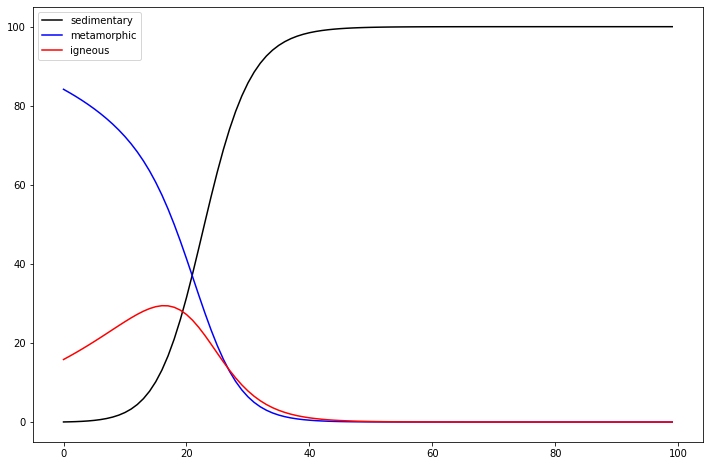

In [12]:
plt.figure(figsize = (12, 8))

plt.plot(x, (theta_sed/theta_total)*100, color = 'k', label = 'sedimentary')
plt.plot(x, (theta_mtm/theta_total)*100, color = 'b', label = 'metamorphic')
plt.plot(x, (theta_ig/theta_total)*100, color = 'r', label = 'igneous')
plt.legend()

In [28]:
dtheta

NameError: name 'dtheta' is not defined

In [ ]:
theta_sed